In [1]:
import os 
os.environ['JAX_JIT_PJIT_API_MERGE'] = '0'
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

# Define undriven system using scqubits, then convert to qiskit

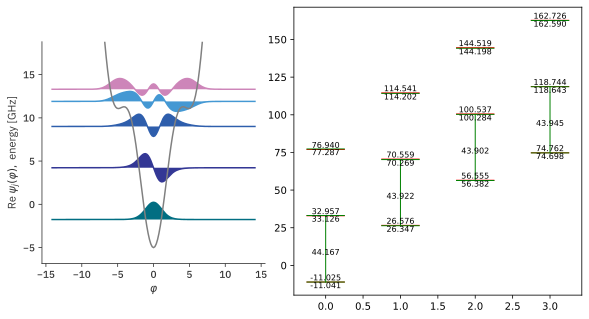

In [2]:
EJ=5
EC=1
EL=1
g_strength = 0.3

qubit_level = 4
osc_level = 4


import qutip
import scqubits
import numpy as np
from matplotlib import pyplot as plt
import math

def generate_single_mapping(H_with_interaction_no_drive) -> np.ndarray:
    """
    Returns a dictionary like {(0,0,0):0,(0,0,1):1}
    """
    evals, evecs = H_with_interaction_no_drive.eigenstates()
    overlap_matrix = scqubits.utils.spectrum_utils.convert_evecs_to_ndarray(evecs)
    OVERLAP_THRESHOLD = 0.01
    product_state_names = []
    dims = H_with_interaction_no_drive.dims[0]
    system_size = len(dims)
    def generate_product_states(current_state, ele_index):
        if ele_index == system_size:
            product_state_names.append(tuple(current_state))
            return
        
        for l in range(dims[ele_index]):
            current_state[ele_index] = l
            generate_product_states(current_state.copy(), ele_index + 1)

    current_state = [0] * system_size
    generate_product_states(current_state, 0)

    total_dim = math.prod(dims)
    dressed_indices = [None] * total_dim
    for dressed_index in range(len(evals)):
        max_position = (np.abs(overlap_matrix[dressed_index, :])).argmax()
        max_overlap = np.abs(overlap_matrix[dressed_index, max_position])
        if (max_overlap**2 > OVERLAP_THRESHOLD):
            overlap_matrix[:, max_position] = 0
            dressed_indices[int(max_position)] = dressed_index
        else:
            print(f'max overlap^2 {max_overlap**2} below threshold for dressed state {dressed_index} with eval {evals[dressed_index]}')
    product_to_dressed = {}
    for product, dressed in zip(product_state_names,dressed_indices):
        product_to_dressed[product] = dressed
    return product_to_dressed

qbt = scqubits.Fluxonium(
        EJ=EJ,
        EC=EC,
        EL=EL,
        flux=0,
        cutoff=30,
        truncated_dim=qubit_level
    )
osc = scqubits.Oscillator(
    E_osc=7,
    truncated_dim=osc_level
)
hilbertspace = scqubits.HilbertSpace([qbt, osc])
hilbertspace.add_interaction(
    g_strength=g_strength,
    op1=qbt.n_operator,
    op2=osc.creation_operator,
    add_hc=True
)
hilbertspace.generate_lookup()
product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())

def plot_specturum(qubit, resonator, hilbertspace, max_qubit_level = 4,max_resonator_level=3,
                    flagged_transitions = [[[0,0],[0,1]],[[1,0],[1,1]],[[2,0],[2,1]],[[3,0],[3,1]]]):
    product_to_dressed = generate_single_mapping(hilbertspace.hamiltonian())
    energy_text_size = 8
    # clear_output(wait=True)
    qubit_ori_energies = qubit.eigenvals(max_qubit_level)
    resonator_ori_energies = resonator.eigenvals(max_resonator_level)
    fig, old_ax = qubit.plot_wavefunction(which = [0,1,2,3,4])
    left, bottom, width, height = 1, 0, 1, 1  
    ax = fig.add_axes([left, bottom, width, height])
    fig.set_size_inches(4, 4)
    for ql in range(0,max_qubit_level):
        for rl in range(0,max_resonator_level):
            original = (qubit_ori_energies[ql] + resonator_ori_energies[rl])* 2 * np.pi
            x1,x2 = ql-0.25,ql+0.25
            ax.plot([x1, x2], [original, original], linewidth=1, color='red')
            ax.text(ql, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom')

            dressed_state_index = product_to_dressed[(ql,rl)]
            dressed = hilbertspace.energy_by_dressed_index(dressed_state_index)* 2 * np.pi
            ax.plot([x1, x2], [dressed, dressed], linewidth=1, color='green')
            ax.text(ql, dressed, f"{dressed:.3f}", fontsize=energy_text_size, ha='center', va='top')

    for transition in flagged_transitions:
        state1, state2 = transition[0],transition[1]
        dressed_index1 = product_to_dressed[(state1[0],state1[1])]
        dressed_index2 = product_to_dressed[(state2[0],state2[1])]
        if dressed_index1!= None and dressed_index2!= None:
            energy1 = hilbertspace.energy_by_dressed_index(dressed_index1)* 2 * np.pi
            energy2 = hilbertspace.energy_by_dressed_index(dressed_index2)* 2 * np.pi
            ax.plot([state1[0], state2[0]], [energy1, energy2], linewidth=1, color='green')
            ax.text((state1[0]+ state2[0])/2, (energy1+ energy2)/2, f"{energy2-energy1:.3f}", fontsize=energy_text_size, ha='center', va='top')
        else:
            print("dressed_state_index contain None")
    plt.show()



plot_specturum(qbt, osc, hilbertspace)


In [3]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver


def qobj_to_operator(matrix):
    if type(matrix) == qutip.qobj.Qobj:
        matrix = matrix.full()
    return Operator(matrix, input_dims = (matrix.shape[0],),output_dims = (matrix.shape[1],))

(evals,) = hilbertspace["evals"]
diag_matrix = np.diag(evals)
static_hamiltonian = 2 * np.pi * qobj_to_operator(diag_matrix)


In [4]:

leakage_dressed_state_osc_0 = product_to_dressed[(0,0)]
leakage_dressed_state_osc_1 = product_to_dressed[(0,1)]

tot_time = 50
a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
matrix_element_driven = abs((a+a.dag()).data.toarray()[leakage_dressed_state_osc_0][leakage_dressed_state_osc_1])
base_drive_amplitude = 1/tot_time
base_drive_amplitude = base_drive_amplitude/matrix_element_driven
driven_operator = 2 * np.pi * base_drive_amplitude * (qobj_to_operator(a)+qobj_to_operator(a.dag()))

In [5]:
ham_solver = Solver(
    hamiltonian_operators=[driven_operator],
    static_hamiltonian=static_hamiltonian,
    # rotating_frame=static_hamiltonian,
)

# Define parameterized discreate signal with gaussian filter

In [21]:
from qiskit_dynamics import DiscreteSignal
from qiskit_dynamics.array import Array
from qiskit_dynamics.signals.transfer_functions import BaseTransferFunction
from qiskit_dynamics.signals import Signal
from typing import Callable



def transition_frequency(hilbertspace,s0: int, s1: int) -> float:
    return ((
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        ))
w_d = transition_frequency(hilbertspace,leakage_dressed_state_osc_0,leakage_dressed_state_osc_1 )
carrier_freq = w_d * 2 * np.pi
signal_sample_dt = 0.5



import sympy as sym
from qiskit import pulse
def lifted_gaussian(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)


def gaussian_square_generated_by_pulse(params):

    sigma, width = params
    _t, _duration, _amp, _sigma, _width, _angle = sym.symbols(
        "t, duration, amp, sigma, width, angle"
    )
    _center = _duration / 2

    _sq_t0 = _center - _width / 2
    _sq_t1 = _center + _width / 2

    _gaussian_ledge = lifted_gaussian(_t, _sq_t0, -1, _sigma)
    _gaussian_redge = lifted_gaussian(_t, _sq_t1, _duration + 1, _sigma)

    envelope_expr = (
        _amp
        * sym.exp(sym.I * _angle)
        * sym.Piecewise(
            (_gaussian_ledge, _t <= _sq_t0), (_gaussian_redge, _t >= _sq_t1), (1, True)
        )
    )

    return pulse.ScalableSymbolicPulse(
            pulse_type="GaussianSquare",
            duration=tot_time,
            amp=1,
            angle=0,
            parameters={"sigma": sigma, "width": width},
            envelope=envelope_expr,
            constraints=sym.And(_sigma > 0, _width >= 0, _duration >= _width),
            valid_amp_conditions=sym.Abs(_amp) <= 1.0,
        )


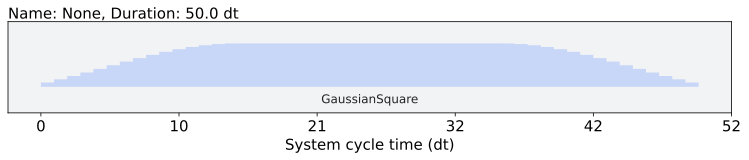

In [24]:
initial_params = np.array([10, 20])
gaussian_square_generated_by_pulse(initial_params).draw()

# Define objective function using qiskit solver

In [26]:
import jax.numpy as jnp
tot_dims = a.shape[0]
g0 = jnp.zeros(tot_dims).at[product_to_dressed[(0, 0)]].set(1).reshape(-1, 1)
g0_op = jnp.outer(g0, jnp.conj(g0).T)
e0 = jnp.zeros(tot_dims).at[product_to_dressed[(1, 0)]].set(1).reshape(-1, 1)
e0_op = jnp.outer(e0, jnp.conj(e0).T)
f0 = jnp.zeros(tot_dims).at[product_to_dressed[(2, 0)]].set(1).reshape(-1, 1)
f0_op = jnp.outer(f0, jnp.conj(f0).T)

pn_op = jnp.array((a.dag()*a).full())
a_op = jnp.array(a.full())


In [41]:
t_list =  jnp.linspace(0,tot_time, int(tot_time)*2).tolist()

from qiskit_dynamics.pulse import InstructionToSignals


dt = signal_sample_dt
w = carrier_freq


def objective(params):

    instance = gaussian_square_generated_by_pulse(params)

    with pulse.build() as Xp:
        pulse.play(instance, pulse.DriveChannel(0))

    converter = InstructionToSignals(dt, carriers={"d0": w})
    signal = converter.get_signals(Xp)
    
    # inital state g0, we want big photon number at the end 
    result_g0 = ham_solver.solve(
        y0=g0,
        t_span=[0, tot_time],
        signals=[signal],
        method='jax_odeint',
        atol=1e-8,
        rtol=1e-8
    )[0]
    ket = result_g0.y[-1]
    photon_num = jnp.linalg.multi_dot([jnp.conj(ket).T,pn_op,ket])
    # print(f"photon_num {photon_num[0][0]}")

    # inital state e0, we want small oscillation of dressed e0 state
    result_e0 = ham_solver.solve(
        y0=e0,
        t_span=[0, tot_time],
        signals=[signal],
        method='jax_odeint',
        t_eval = t_list,
        atol=1e-8,
        rtol=1e-8
    )[0]
    sum_e0_pop = sum([jnp.linalg.multi_dot([jnp.conj(ket).T, e0_op, ket]) for ket in result_e0.y]) 
    # print(f"sum_e0_pop {sum_e0_pop[0][0]}")


    # inital state f0, we want small oscillation of dressed f0 state
    result_f0 = ham_solver.solve(
        y0=f0,
        t_span=[0, tot_time],
        signals=[signal],
        method='jax_odeint',
        t_eval =t_list,
        atol=1e-8,
        rtol=1e-8
    )[0]
    sum_f0_pop = sum([jnp.linalg.multi_dot([jnp.conj(ket).T,f0_op,ket]) for ket in result_f0.y])
    # print(f"sum_f0_pop {sum_f0_pop[0][0]}")

    cost = - 30 * photon_num - sum_e0_pop - sum_f0_pop
    
    cost = jnp.real(cost)
    cost = cost[0][0]
    # print(cost)
    return cost

In [42]:
from jax import jit, value_and_grad
from scipy.optimize import minimize

jit_grad_obj = jit(value_and_grad(objective))

opt_results = minimize(fun=jit_grad_obj, x0=initial_params, jac=True, method='BFGS')

print(opt_results.message)
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))

photon_num Traced<ShapedArray(complex128[])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(complex128[])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(complex128[])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(complex128[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x28bad3100>, in_tracers=(Traced<ShapedArray(complex128[1]):JaxprTrace(level=1/1)>,), out_tracer_refs=[<weakref at 0x28b9a10d0; to 'JaxprTracer' at 0x28b9a3650>], out_avals=[ShapedArray(complex128[])], primitive=squeeze, params={'dimensions': (0,)}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x28befd930>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
Optimization terminated successfully.
Number of function evaluations: 1
Function value: -199.99767270999368


# Get the result out

In [43]:
opt_results

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -199.99767270999368
        x: [ 1.000e+01  2.000e+01]
      nit: 0
      jac: [ 1.722e-07  2.045e-07]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 1
     njev: 1

In [44]:
instance = gaussian_square_generated_by_pulse(opt_results.x)

with pulse.build() as Xp:
    pulse.play(instance, pulse.DriveChannel(0))

converter = InstructionToSignals(dt, carriers={"d0": w})
signal = converter.get_signals(Xp)
# inital state g0, we want big photon number at the end 

results = []
for y0 in [g0,e0,f0]:
    result = ham_solver.solve(
        y0=y0,
        t_span=[0, tot_time],
        signals=[signal],
        method='jax_odeint',
        t_eval = t_list,
        atol=1e-8,
        rtol=1e-8
    )[0]
    results.append(result)

In [45]:
# In case alpha oscillates not at drive frequency 
def find_dominant_frequency(expectation,tlist,dominant_frequency_already_found = None,plot = False):
    if dominant_frequency_already_found != None:
        expectation = expectation * np.exp(-1j*2*np.pi*dominant_frequency_already_found*tlist)

    expectation_fft = np.fft.fft(expectation)
    frequencies = np.fft.fftfreq(len(tlist), d=(tlist[1] - tlist[0]))  # assuming tlist is uniformly spaced

    # Identify the dominant frequency: 
    # (we exclude the zero frequency, which usually has the DC offset)
    dominant_freq_idx = np.argmax(np.abs(expectation_fft[1:])) + 1
    dominant_freq = frequencies[dominant_freq_idx]

    if plot:
        # Print the dominant frequency
        print(f"The dominant oscillation frequency is: {dominant_freq:.3f} (in the same units as 1/timestep)")

        fft_shifted = np.fft.fftshift(expectation_fft)
        frequencies_shifted = np.fft.fftshift(frequencies)
        plt.plot(frequencies_shifted, np.abs(fft_shifted))
        plt.xlabel('Frequency (arbitrary units)')
        plt.ylabel('Magnitude')
        plt.title('FFT of the Expectation Value')
        plt.grid(True)
        plt.show()
    else:
        return dominant_freq


 /Users/jiakaiwang/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/matplotlib/cbook/__init__.py: 1335

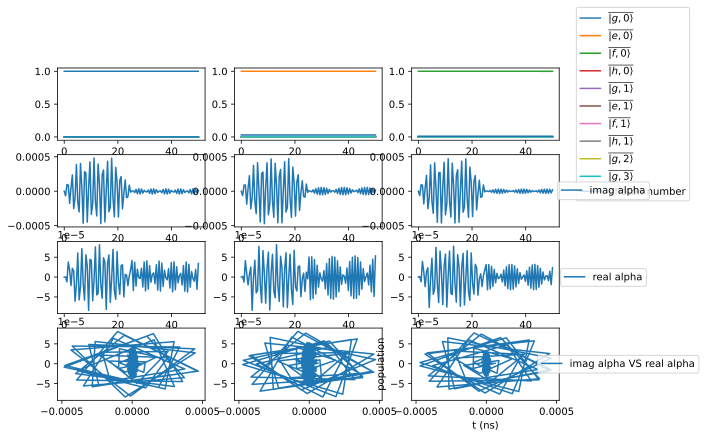

In [46]:
dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}
product_states = [(0, 0), (1, 0), (2,0), (3,0),  (0, 1), (1, 1), (2,1),(3,1),(0,2),(0,3)]
dressed_idxs = [product_to_dressed[(s1, s2)] for (s1, s2) in product_states]

nlevels = 3

fig, axes = plt.subplots(4, nlevels, figsize=(9, 6))

for i in range(nlevels):
    states = jnp.array(results[i].y)
    for idx in dressed_idxs:
        product_state = product_states[dressed_idxs.index(idx)]
        qubit_state = dictionary[product_state[0]]
        resonator_state = product_state[1]
        dressed_state = jnp.zeros(tot_dims).at[idx].set(1).reshape(-1, 1)
        dressed_state_op = jnp.outer(dressed_state, jnp.conj(dressed_state).T)
        expectations = [jnp.linalg.multi_dot([jnp.conj(ket).T,dressed_state_op,ket])[0][0]       for ket in states]
        axes[0][i].plot(t_list, expectations, label=r"$\overline{|%s\rangle}$" % (str(",".join([qubit_state,str(resonator_state)]))))
    

    alpha = jnp.array([jnp.linalg.multi_dot([jnp.conj(ket).T,a_op,ket])[0][0]       for ket in states]) #*np.exp(-1j * 2 * np.pi * first_dominant_freq * tlist) # *np.exp(-1j * 2 * np.pi * dominant_freq * tlist)  
    real = alpha.real
    imag = alpha.imag

    pns = [jnp.linalg.multi_dot([jnp.conj(ket).T,pn_op,ket])[0][0]       for ket in states]
    axes[0][i].plot(t_list, pns, label=r"photon number")
    axes[1][i].plot(t_list,imag , label=r"imag alpha")
    axes[2][i].plot(t_list, real, label=r"real alpha")
    axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")

axes[0][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
axes[1][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[2][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[3][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
plt.ylabel("population")
plt.xlabel("t (ns)")
for row in [0,1,2,3]:
    max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
    for col in range(nlevels):
        ymin, ymax = axes[row][col].get_ylim()
        xmin, xmax = axes[row][col].get_xlim()
        if ymax > max_y_range:
            max_y_range = ymax
        if ymin < min_y_range:
            min_y_range = ymin
        if xmax > max_x_range:
            max_x_range = xmax
        if xmin < min_x_range:
            min_x_range = xmin
    for col in range(nlevels):
        axes[row][col].set_ylim(min_y_range, max_y_range)
        axes[row][col].set_xlim(min_x_range,max_x_range)
# plt.yscale('log')
plt.show()